# Import

In [1]:
import sys
import pickle
from tqdm.auto import tqdm
import os

C:\Users\48ven\anaconda3\envs\chex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path

['D:\\Lab\\x-ray\\hybrid_segm',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex\\python38.zip',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex\\DLLs',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex\\lib',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex',
 '',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex\\lib\\site-packages',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex\\lib\\site-packages\\win32',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\48ven\\anaconda3\\envs\\chex\\lib\\site-packages\\Pythonwin']

In [3]:
sys.path.append('c:\\users\\48ven\\anaconda3\\envs\\torch-tf\\lib\\site-packages')

In [4]:
import numpy as np
import cv2 

from models.HybridGNet2IGSC import Hybrid 
from utils.utils import scipy_to_torch_sparse, genMatrixesLungsHeart
import scipy.sparse as sp
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tfrecord.torch.dataset import TFRecordDataset
import tfrecord
import cv2
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hybrid = None

In [6]:
feature_description = {
    'jpg_bytes': "byte",
    'subject_id': "int",
    'study_id': "int",
    'No Finding': "float",
    'Pleural Effusion': "float"
}

label_list = ['Pneumothorax', 'Pneumonia', 'Pleural Effusion', 'No Finding', 'Atelectasis', 'Lung Opacity','Enlarged Cardiomediastinum', 'Edema', 'Consolidation', 'Cardiomegaly']

In [7]:
train_filename = '../data/new_mimic_train.tfrecords'

# Data

In [8]:
loader = tfrecord.tfrecord_loader(train_filename, None, feature_description)

In [9]:
for record in loader:
    nparr = np.fromstring(record["jpg_bytes"], np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    break

C:\Users\48ven\AppData\Local\Temp\ipykernel_7456\1555687005.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(record["jpg_bytes"], np.uint8)


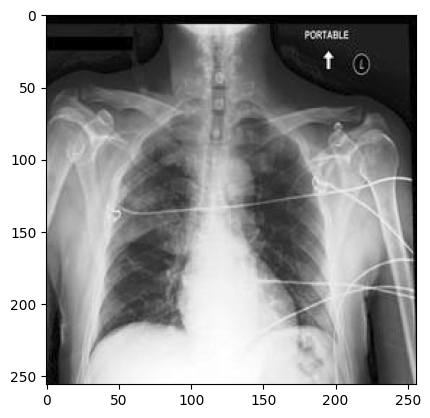

In [10]:
plt.imshow(img_np, cmap='gray')
plt.show()

In [11]:
data_val = pd.read_csv("D:\\Lab\\CheXpert\\new_val.csv")
data_test = pd.read_csv("D:\\Lab\\CheXpert\\new_test.csv")

In [12]:
def getDenseMask(landmarks, h, w):
    
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    img = np.zeros([h, w], dtype = 'uint8')
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 1, -1)
    img = cv2.drawContours(img, [H], -1, 2, -1)
    
    return img

def getMasks(landmarks, h, w):
    
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')
    
    RL_mask = np.zeros([h, w], dtype = 'uint8')
    LL_mask = np.zeros([h, w], dtype = 'uint8')
    H_mask = np.zeros([h, w], dtype = 'uint8')
    
    RL_mask = cv2.drawContours(RL_mask, [RL], -1, 255, -1)
    LL_mask = cv2.drawContours(LL_mask, [LL], -1, 255, -1)
    H_mask = cv2.drawContours(H_mask, [H], -1, 255, -1)

    return RL_mask, LL_mask, H_mask

def drawOnTop(img, landmarks, original_shape):
    h, w = original_shape
    output = getDenseMask(landmarks, h, w)
    
    image = np.zeros([h, w, 3])
    image[:,:,0] = img + 0.3 * (output == 1).astype('float') - 0.1 * (output == 2).astype('float')
    image[:,:,1] = img + 0.3 * (output == 2).astype('float') - 0.1 * (output == 1).astype('float') 
    image[:,:,2] = img - 0.1 * (output == 1).astype('float') - 0.2 * (output == 2).astype('float') 

    image = np.clip(image, 0, 1)
    
    RL, LL, H = landmarks[0:44], landmarks[44:94], landmarks[94:]
    
    # Draw the landmarks as dots
    
    for l in RL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in LL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in H:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 1, 0), -1)
    
    return image
    

def loadModel(device):    
    A, AD, D, U = genMatrixesLungsHeart()
    N1 = A.shape[0]
    N2 = AD.shape[0]

    A = sp.csc_matrix(A).tocoo()
    AD = sp.csc_matrix(AD).tocoo()
    D = sp.csc_matrix(D).tocoo()
    U = sp.csc_matrix(U).tocoo()

    D_ = [D.copy()]
    U_ = [U.copy()]

    config = {}

    config['n_nodes'] = [N1, N1, N1, N2, N2, N2]
    A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
    
    A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

    config['latents'] = 64
    config['inputsize'] = 1024

    f = 32
    config['filters'] = [2, f, f, f, f//2, f//2, f//2]
    config['skip_features'] = f

    hybrid = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
    hybrid.load_state_dict(torch.load("weights/weights.pt", map_location=torch.device(device)))
    hybrid.eval()
    
    return hybrid


def pad_to_square(img):
    h, w = img.shape[:2]
    
    if h > w:
        padw = (h - w) 
        auxw = padw % 2
        img = np.pad(img, ((0, 0), (padw//2, padw//2 + auxw)), 'constant')
        
        padh = 0
        auxh = 0
        
    else:
        padh = (w - h) 
        auxh = padh % 2
        img = np.pad(img, ((padh//2, padh//2 + auxh), (0, 0)), 'constant')

        padw = 0
        auxw = 0
        
    return img, (padh, padw, auxh, auxw)
    

def preprocess(input_img):
    img, padding = pad_to_square(input_img)
    
    h, w = img.shape[:2]
    if h != 1024 or w != 1024:
        img = cv2.resize(img, (1024, 1024), interpolation = cv2.INTER_CUBIC)
        
    return img, (h, w, padding)


def removePreprocess(output, info):
    h, w, padding = info
    
    if h != 1024 or w != 1024:
        output = output * h
    else:
        output = output * 1024
    
    padh, padw, auxh, auxw = padding
    
    output[:, 0] = output[:, 0] - padw//2
    output[:, 1] = output[:, 1] - padh//2
    
    return output 

In [13]:
def segment(input_img):
    global hybrid, device
    
    if hybrid is None:
        hybrid = loadModel(device)
    
    # input_img = cv2.imread(input_img, 0) / 255.0
    original_shape = input_img.shape[:2]
    
    img, (h, w, padding) = preprocess(input_img)    
        
    data = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device).float()
    
    with torch.no_grad():
        output = hybrid(data)[0].cpu().numpy().reshape(-1, 2)
        
    output = removePreprocess(output, (h, w, padding))
    
    output = output.astype('int')
    
    outseg = drawOnTop(input_img, output, original_shape) 
    
    seg_to_save = (outseg.copy() * 255).astype('uint8')
    # cv2.imwrite("tmp/overlap_segmentation.png" , cv2.cvtColor(seg_to_save, cv2.COLOR_RGB2BGR))
    
    RL = output[0:44]
    LL = output[44:94]
    H = output[94:]
            
    # np.savetxt("tmp/RL_landmarks.txt", RL, delimiter=" ", fmt="%d")
    # np.savetxt("tmp/LL_landmarks.txt", LL, delimiter=" ", fmt="%d")
    # np.savetxt("tmp/H_landmarks.txt", H, delimiter=" ", fmt="%d")
    
    RL_mask, LL_mask, H_mask = getMasks(output, original_shape[0], original_shape[1])
    mask = np.zeros((original_shape[0], original_shape[1]))
    mask = cv2.bitwise_or(mask, RL_mask / 255)
    mask = cv2.bitwise_or(mask, LL_mask / 255)
    # mask = cv2.bitwise_or(mask, H_mask / 255)
    
    # cv2.imwrite("tmp/RL_mask.png", RL_mask)
    # cv2.imwrite("tmp/LL_mask.png", LL_mask)
    # cv2.imwrite("tmp/H_mask.png", H_mask) 
    # cv2.imwrite("tmp/mask.png", output) 
    
    return mask

In [17]:
loader = tfrecord.tfrecord_loader(train_filename, None, feature_description)
for record in tqdm(loader):
    target_path = str(record["study_id"][0])
    label = 1 if int(record["Pleural Effusion"][0]) == 1 else 0
    if label == 1:
        continue
    # if label == 1:
    #     continue
    nparr = np.fromstring(record["jpg_bytes"], np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE) / 255
    mask = segment(img_np)
    with open('../segmentation_hybrid/train_wo_heart/' + target_path + '.pkl','wb') as f:
        pickle.dump(mask, f)

0it [00:00, ?it/s]C:\Users\48ven\AppData\Local\Temp\ipykernel_7456\70015387.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(record["jpg_bytes"], np.uint8)
64955it [22:05, 48.99it/s] 


# chexpert

In [15]:
data_val = pd.read_csv("D:\\Lab\\CheXpert\\new_val.csv")
data_test = pd.read_csv("D:\\Lab\\CheXpert\\new_test.csv")

In [16]:
img_path_val, img_path_test = data_val['Path'].to_numpy(), data_test['Path'].to_numpy()
target_label_val, target_label_test = [], []
for each in data_val['No Finding']:
    target_label_val.append(0 if each == 1 else 1)
    
for each in data_test['No Finding']:
    target_label_test.append(0 if each == 1 else 1)

In [18]:
for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    target_path = '_'.join(target_path)
    
    if label == 0:
        continue
    input_img = cv2.imread(path, 0) / 255.0
    mask = segment(input_img)
    
    with open('../segmentation_hybrid/val_wo_heart/' + target_path + '.pkl','wb') as f:
        pickle.dump(mask, f)

90it [01:31,  1.01s/it]


In [19]:
for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    target_path = '_'.join(target_path)
    
    if label == 0:
        continue
    input_img = cv2.imread(path, 0) / 255.0
    mask = segment(input_img)
    
    with open('../segmentation_hybrid/test_wo_heart/' + target_path + '.pkl','wb') as f:
        pickle.dump(mask, f)

173it [16:41,  5.79s/it]


(-0.5, 2827.5, 2319.5, -0.5)

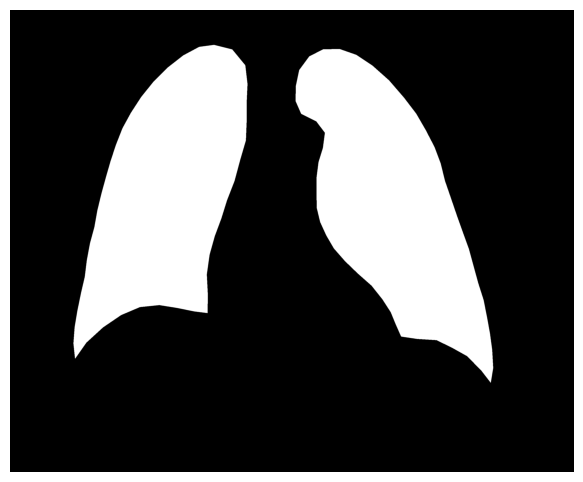

In [21]:
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.imshow(mask, cmap='gray')
# ax.imshow(mask, alpha=0.3)
ax.axis('off')